# **Smart Lele Machine Learning Model Development**

Notebook ini digunakan untuk development model dari project Smart Lele.

Beberapa link yang terkait:
- [Dataset]()
- [GitHub]()

## 1. Import Libraries

In [ ]:
!pip install keras_tuner
!pip install "everywhereml>=0.2.32"

In [ ]:
# Kaggle API for download dataset
import kagglehub

# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer

# Metrics for evaluation
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc

# Common ML Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# TensorFlow/Keras imports
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

# Utils
import os
from tensorflow.keras.utils import to_categorical

# Deployment
from everywhereml.code_generators.tensorflow import convert_model

## 2. Load and Explore Data

In [ ]:
path = kagglehub.dataset_download("afridatasnimeasha/dataset-of-pondwater-for-fish") + "/realfishdataset.csv"
print(f'Dataset Downloaded to {path}')

df = pd.read_csv(path)

df.head()

Dataset Downloaded to /kaggle/input/dataset-of-pondwater-for-fish/realfishdataset.csv


,ph,temperature,turbidity,fish
0,6.0,27.0,4.0,katla
1,7.6,28.0,5.9,sing
2,7.8,27.0,5.5,sing
3,6.5,31.0,5.5,katla
4,8.2,27.0,8.5,prawn


In [ ]:
df.drop(columns=['fish'], inplace=True)

In [ ]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40280 entries, 0 to 40279
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ph           40280 non-null  float64
 1   temperature  40280 non-null  float64
 2   turbidity    40280 non-null  float64
dtypes: float64(3)
memory usage: 944.2 KB


,ph,temperature,turbidity
count,40280.000000,40280.000000,40280.000000
mean,7.512655,22.000871,4.463909
std,0.810823,4.575368,2.132095
min,5.500000,4.000000,1.000000
25%,6.950000,18.000000,3.480000
50%,7.500000,21.120000,3.570000
75%,8.180000,25.000000,4.120000
max,9.000000,35.000000,15.800000


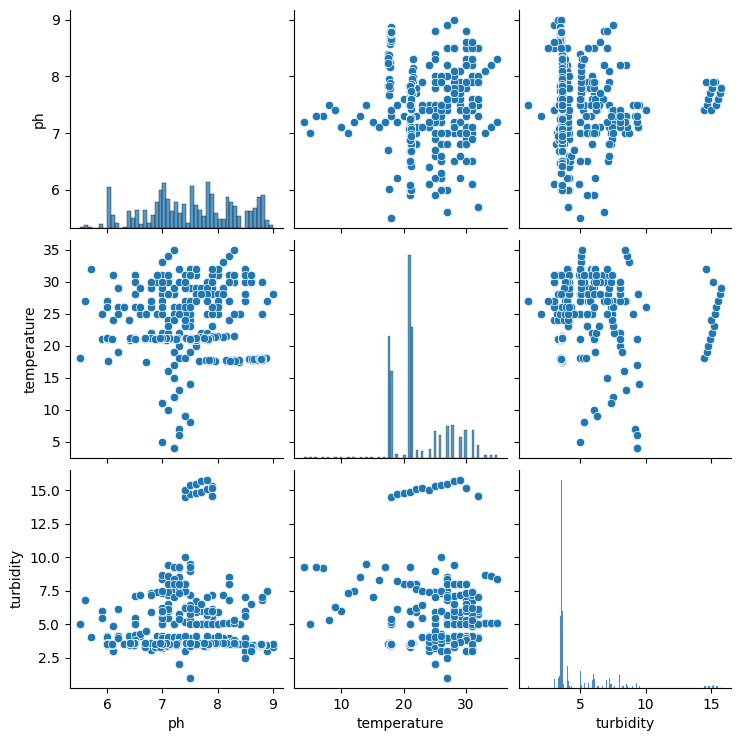

In [ ]:
sns.pairplot(df)

In [ ]:
# Searching for missing values
print("Missing Values : ")
df.isnull().sum()

Missing Values : 


,0
ph,0
temperature,0
turbidity,0


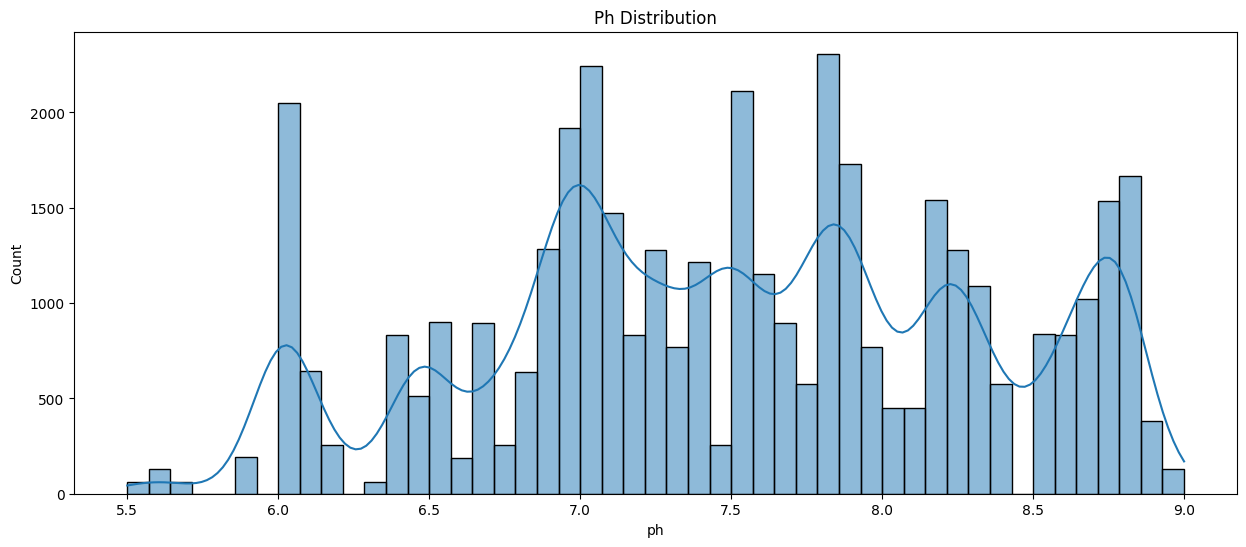

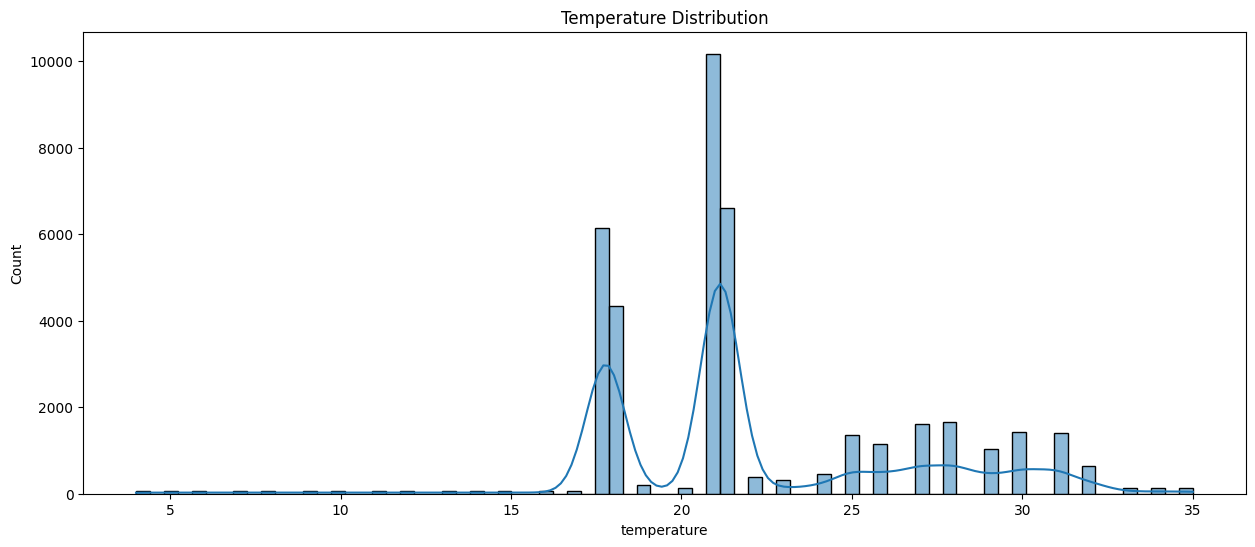

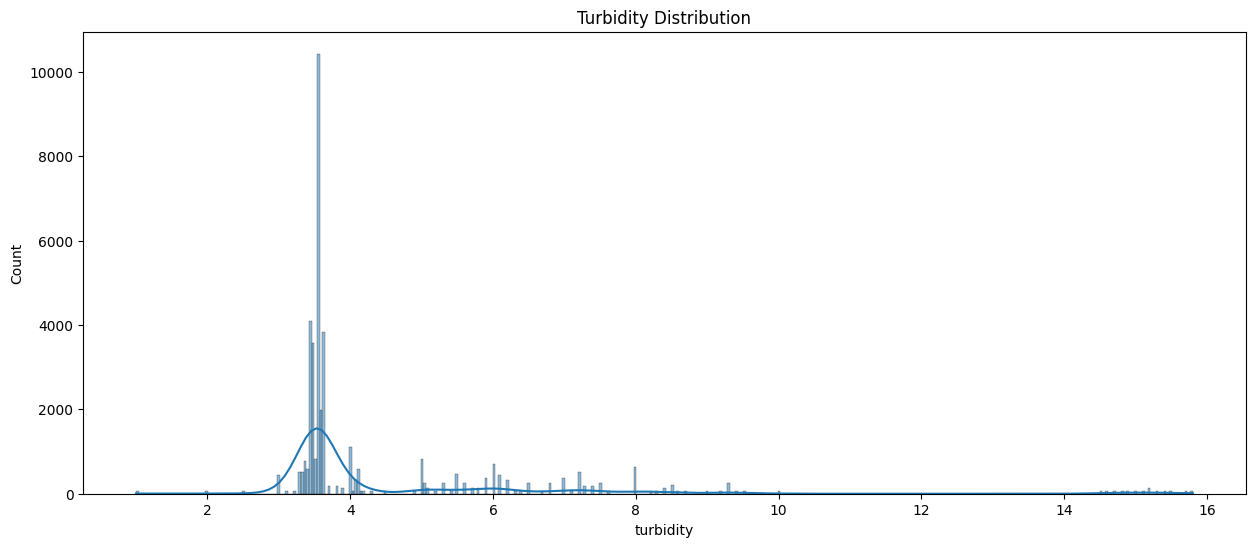

In [ ]:
# Data Distribution
cols = df.columns
for col in cols:
    plt.figure(figsize=(15, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'{col.capitalize()} Distribution')
    plt.show()

## 3. Feature Engineering/Labeling

Untuk memperoleh kondisi optimal bagi pertumbuhan lele, pH air sebaiknya dijaga di kisaran 6,5–8,5, suhu air di 25–30 °C, dan kekeruhan (turbidity) di 0–50 NTU.

Sumber:
- https://snitt.polman-babel.ac.id/index.php/snitt/article/download/264/140?utm_source=chatgpt.com
- https://aquaculture.ca.uky.edu/sites/aquaculture.ca.uky.edu/files/desirable-water-quality-parameters-for-catfish-ponds.pdf?utm_source=chatgpt.com
- https://www.epa.gov/system/files/documents/2022-01/list-of-state-specific-water-quality-standards.pdf?utm_source=chatgpt.com

In [ ]:
def water_classification(ph, suhu, turbidity):
    if 6.5 <= ph <= 8.5 and 25 <= suhu <= 30 and turbidity <= 50:
        return 1
    return 0

df['water_quality'] = df.apply(lambda row: water_classification(row['ph'], row['temperature'], row['turbidity']), axis=1)

df.head()

,ph,temperature,turbidity,water_quality
0,6.0,27.0,4.0,0
1,7.6,28.0,5.9,1
2,7.8,27.0,5.5,1
3,6.5,31.0,5.5,0
4,8.2,27.0,8.5,1


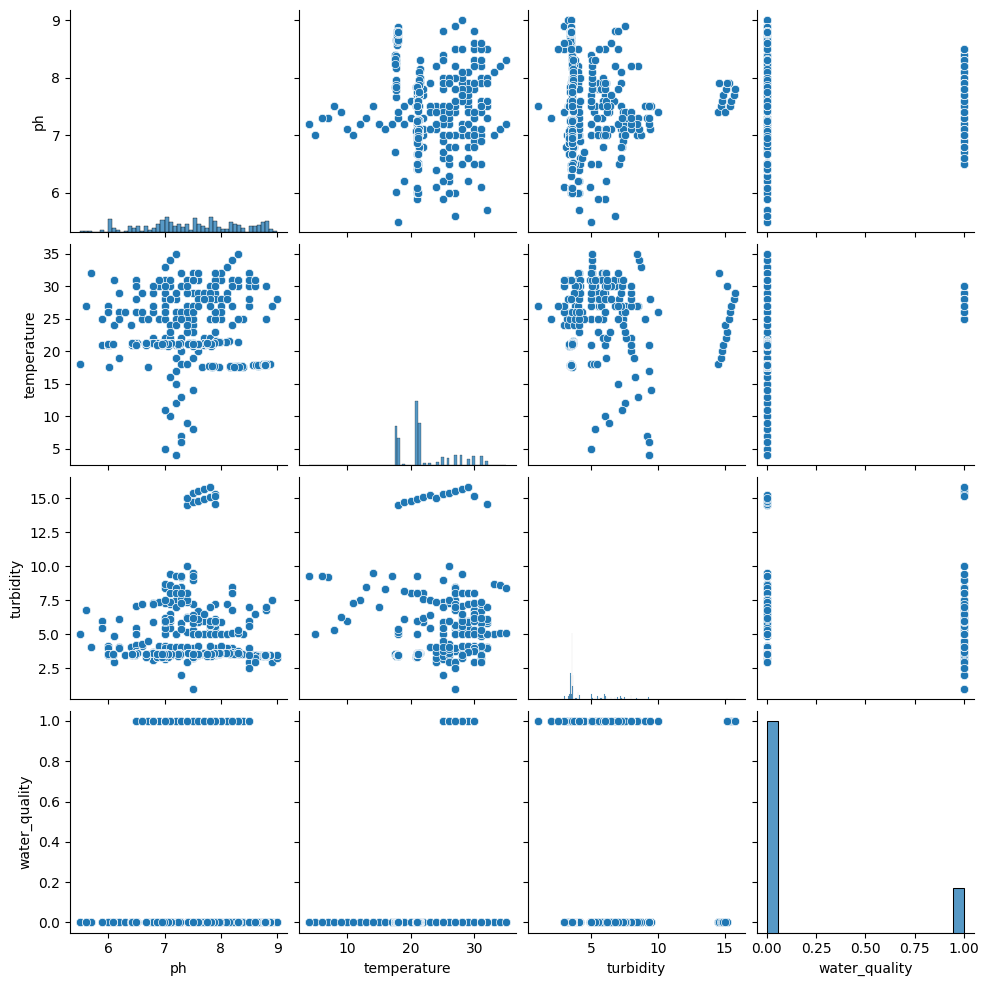

In [ ]:
sns.pairplot(df)
plt.show()

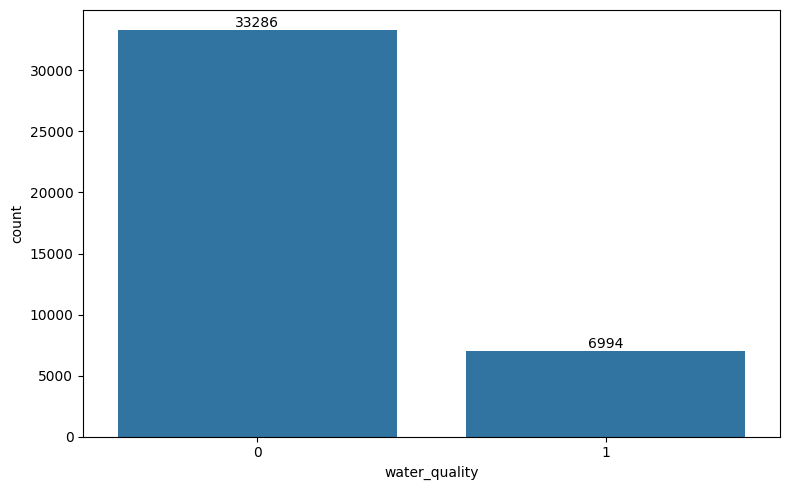

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='water_quality')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()

In [ ]:
# Mengurangi water_quality 0 agar balance
df_majority = df[df.water_quality == 0]
df_minority = df[df.water_quality == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])


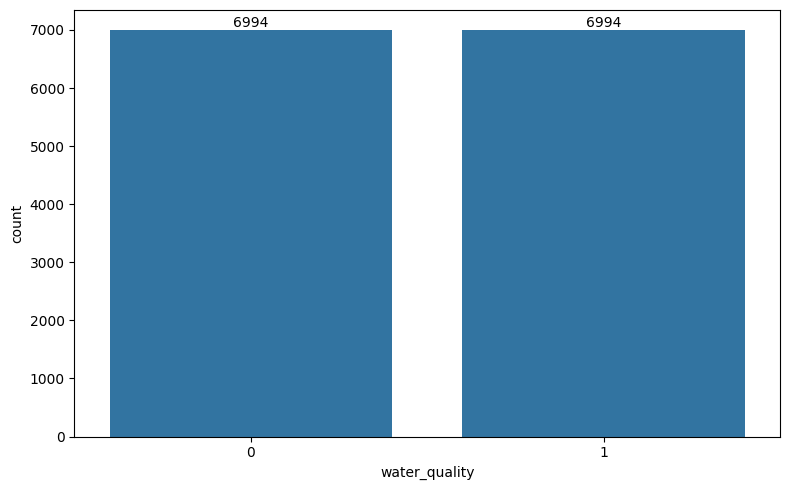

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_balanced, x='water_quality')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()

In [ ]:
df_balanced.shape
df_balanced.info()
df_balanced.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 13988 entries, 13550 to 40266
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ph             13988 non-null  float64
 1   temperature    13988 non-null  float64
 2   turbidity      13988 non-null  float64
 3   water_quality  13988 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 546.4 KB


,ph,temperature,turbidity,water_quality
count,13988.000000,13988.000000,13988.000000,13988.000000
mean,7.500265,24.228911,5.122034,0.500000
std,0.706338,4.592424,2.561515,0.500018
min,5.500000,4.000000,1.000000,0.000000
25%,7.000000,21.060000,3.560000,0.000000
50%,7.500000,25.000000,4.000000,0.500000
75%,7.960000,28.000000,6.000000,1.000000
max,9.000000,35.000000,15.800000,1.000000


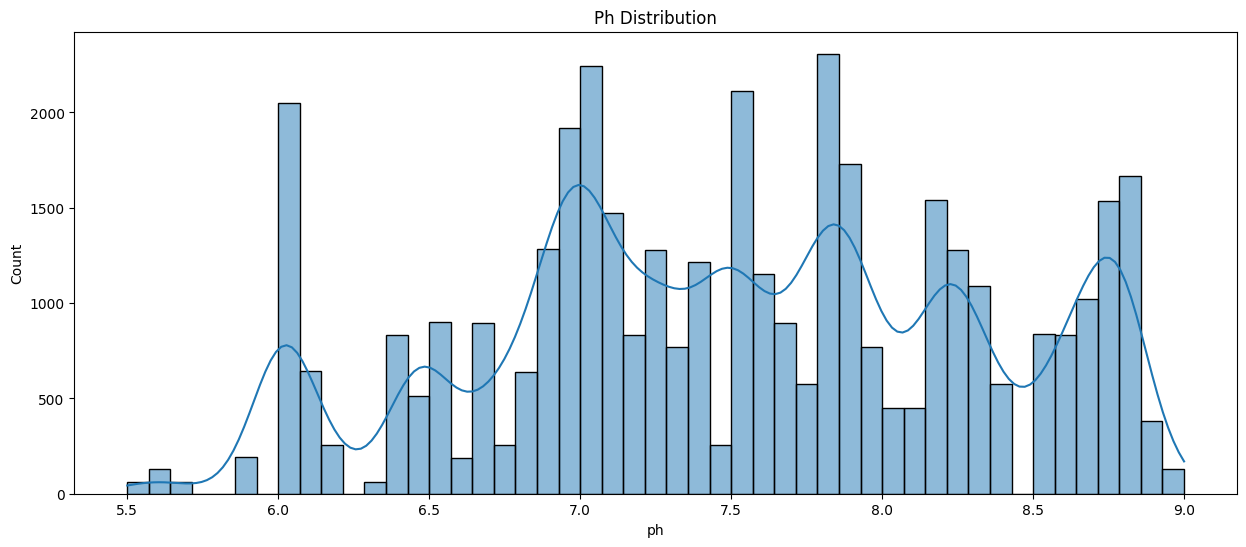

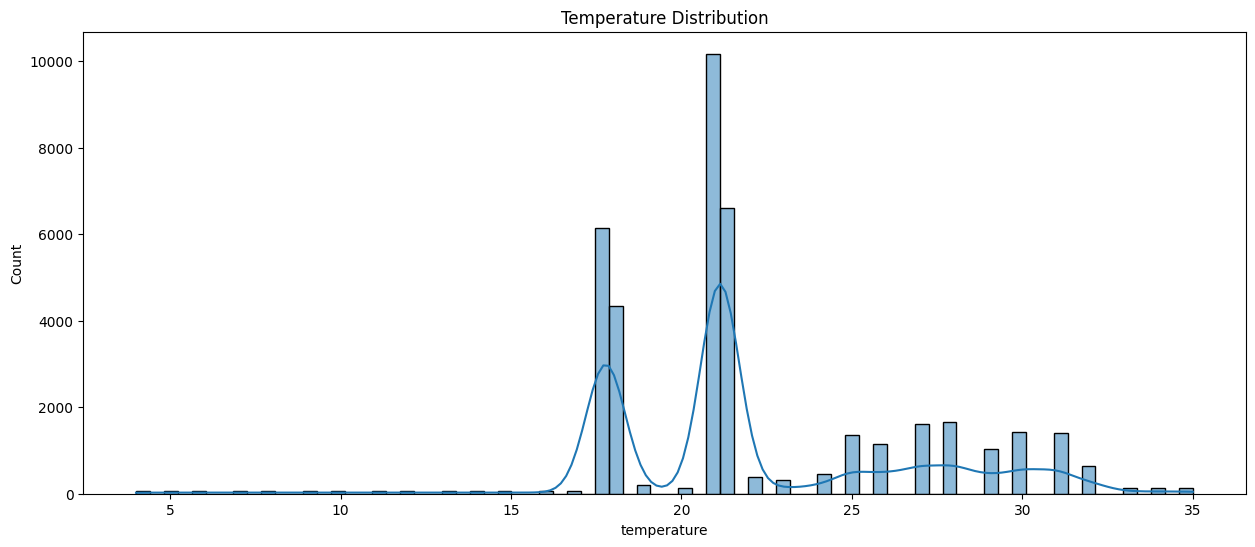

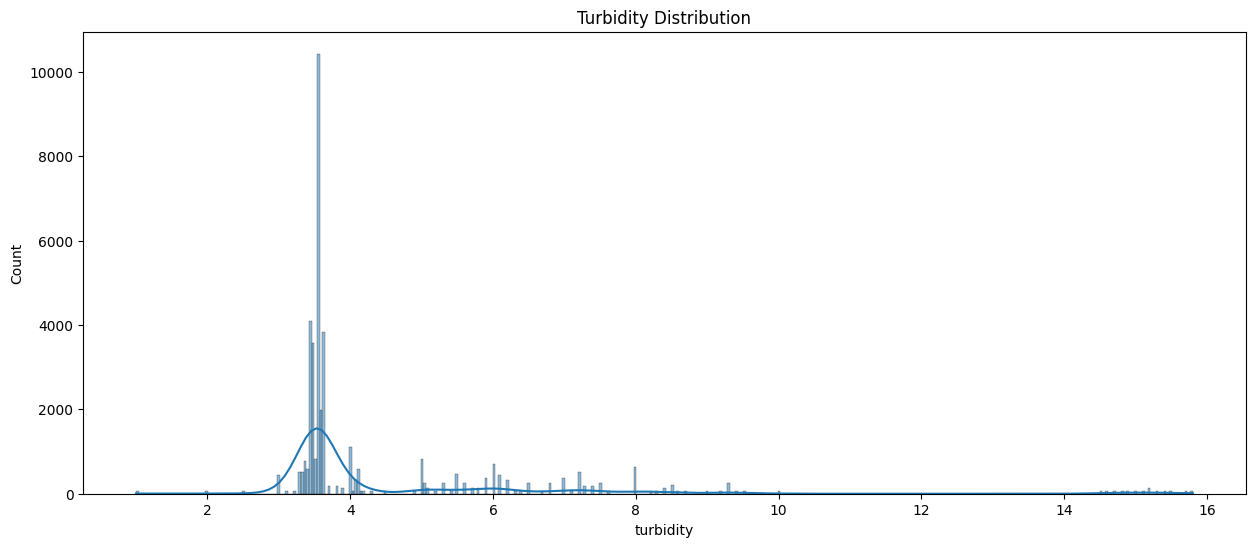

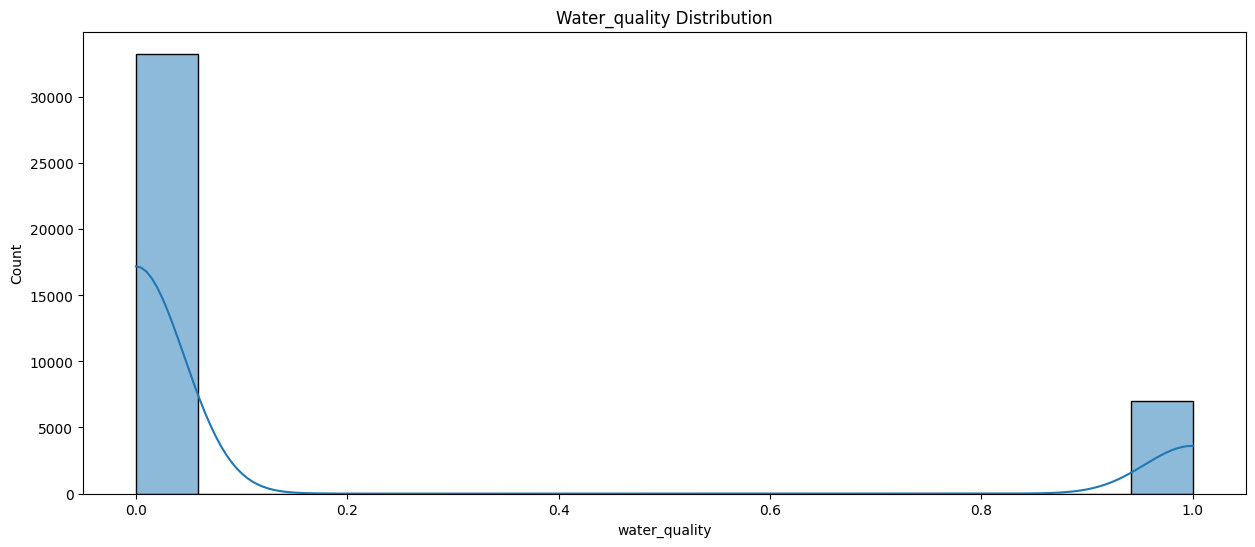

In [ ]:
# Data Distribution
cols = df_balanced.columns
for col in cols:
    plt.figure(figsize=(15, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'{col.capitalize()} Distribution')
    plt.show()

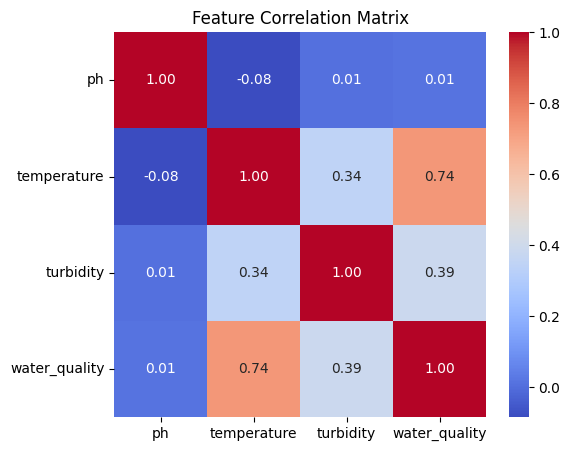

In [ ]:
plt.figure(figsize=(6, 5))
correlation = df_balanced.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Split features and target
X = df_balanced.drop('water_quality', axis=1)
y = df_balanced['water_quality']

In [ ]:
y

,water_quality
13550,0
26669,0
2823,0
33612,0
3315,0
...,...
40261,1
40262,1
40263,1
40264,1


## 4. Data Preprocessing

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_features = ['ph', 'temperature', 'turbidity']

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)

print(f"X_train shape after preprocessing: {X_train_preprocessed.shape}")
print(X_train_preprocessed)

X_train shape after preprocessing: (11190, 3)
[[-0.14455767  1.2647162   0.43015151]
 [ 1.16030189 -1.45317943 -0.60989693]
 [-0.42822279  1.04623585  1.13927544]
 ...
 [-1.44941723 -0.701607   -0.6492927 ]
 [ 1.16030189 -1.45317943 -0.60989693]
 [-0.42822279  0.39079478 -0.4759513 ]]


## 5. Model Selection and Training

In [ ]:
# Evaluate all models including ANN
def evaluate_models_for_edge():
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    }

    scoring = 'accuracy'
    results = []

    for name, clf in classifiers.items():
        # Build pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scoring)

        results.append({
            'Model': name,
            'CV Mean Accuracy': cv_scores.mean(),
            'CV Std Dev': cv_scores.std()
        })

    # Result DataFrame
    results_df = pd.DataFrame(results).sort_values('CV Mean Accuracy', ascending=False)
    return results_df

In [ ]:
def build_ann(hp=None):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))

    units = hp.Int('units', 32, 128, step=32) if hp else 64
    model.add(Dense(units=units, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1]) if hp else 0.001
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def evaluate_ann_tensorflow(X_train, y_train, epochs=30, batch_size=16):
    X_processed = preprocessor.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in skf.split(X_processed, y_train):
        X_fold_train, X_fold_val = X_processed[train_index], X_processed[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = build_ann()
        model.fit(X_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, verbose=0)
        score = model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
        scores.append(score)

    return {
        'Model': 'ANN',
        'CV Mean Accuracy': np.mean(scores),
        'CV Std Dev': np.std(scores)
    }

In [ ]:
edge_model_results = evaluate_models_for_edge()
ann_result = evaluate_ann_tensorflow(X_train, y_train)

combined_results = pd.concat([
    edge_model_results,
    pd.DataFrame([ann_result])
]).sort_values('CV Mean Accuracy', ascending=False)

print("Model comparison results:")
display(combined_results)

Model comparison results:


,Model,CV Mean Accuracy,CV Std Dev
1,Decision Tree,1.000000,0.000000
2,Random Forest,0.999374,0.001042
0,ANN,0.980340,0.003563
0,Logistic Regression,0.930206,0.007339


If `user_input == None` it will choose the best model. Other options:`"ANN", "Decision Tree", "Random Forest", "Logistic Regression"`



In [ ]:
user_input = "ANN" # @param {"type":"raw","placeholder":"Decision Tree, Random Forest, Logistic Regression, ANN"}

In [ ]:
# Ambil nama model terbaik
best_model_name = combined_results.iloc[0]['Model'] if user_input == None else user_input
print(f"The best performing model is: {best_model_name}")

# Buat model terbaik
if best_model_name == 'Logistic Regression':
    best_model = LogisticRegression(max_iter=500, random_state=42)
elif best_model_name == 'Decision Tree':
    best_model = DecisionTreeClassifier(random_state=42)
elif best_model_name == 'Random Forest':
    best_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'ANN':
    best_model = build_ann()
else:
    raise ValueError(f"Unknown model: {best_model_name}")

The best performing model is: ANN


## 6. Hyperparameter Tuning

In [ ]:
def tune_ann(X_train, y_train, preprocessor, max_trials=10):
    X_processed = preprocessor.fit_transform(X_train)

    tuner = kt.RandomSearch(
        lambda hp: build_ann(hp),
        objective='val_accuracy',
        max_trials=max_trials,
        directory='keras_tuner',
        project_name='smart_lele'
    )

    # Split data untuk validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_processed, y_train, test_size=0.2, random_state=42
    )

    # Cari hyperparameter terbaik
    tuner.search(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=30,
        batch_size=32,
        verbose=1
    )

    # Dapatkan model terbaik dan latih ulang untuk mendapatkan history
    best_hps = tuner.get_best_hyperparameters()[0]
    best_model = tuner.hypermodel.build(best_hps)

    history = best_model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    return {
        'Best Model': best_model,
        'Best Hyperparameters': best_hps,
        'Training History': history
    }

Starting ANN hyperparameter tuning with Keras Tuner...
Reloading Tuner from keras_tuner/smart_lele/tuner0.json

Best ANN Hyperparameters:
- Units: 32
- Activation: relu
- Learning Rate: 0.1


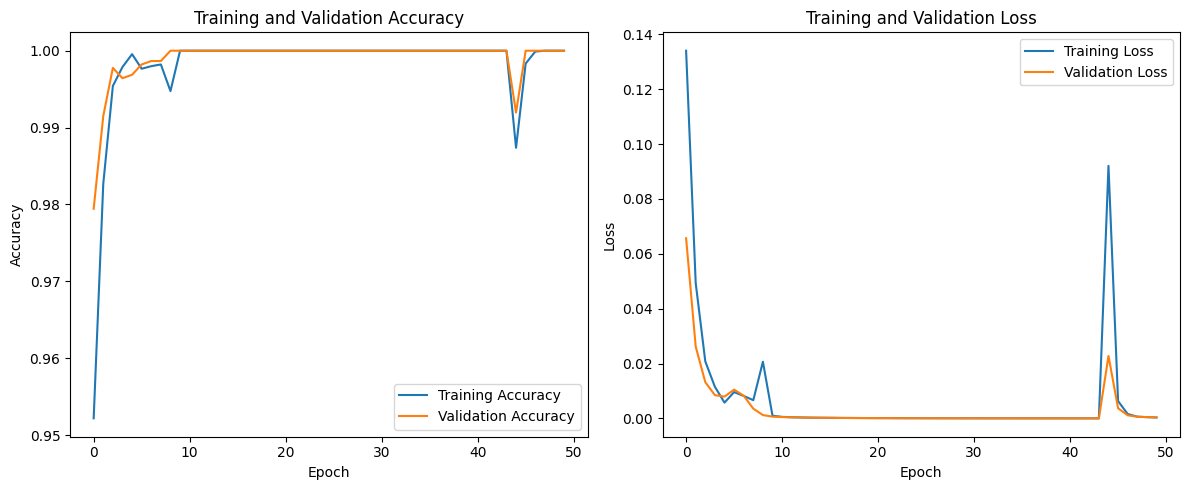


Test Accuracy: 1.0000


In [ ]:
if best_model_name != 'ANN':
  # Pipeline dengan model terbaik
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('model', best_model)
  ])

  # Grid hyperparameter tuning
  if best_model_name == 'Logistic Regression':
      param_grid = {
          'model__C': [0.01, 0.1, 1.0, 10.0],
          'model__solver': ['liblinear', 'saga'],
          'model__penalty': ['l1', 'l2']
      }
  elif best_model_name == 'Decision Tree':
      param_grid = {
          'model__max_depth': [3, 5, 10, None],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4]
      }
  elif best_model_name == 'Random Forest':
      param_grid = {
          'model__n_estimators': [50, 100, 200],
          'model__max_depth': [5, 10, 20, None],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4]
      }

  # GridSearch
  print(f"Tuning hyperparameters for {best_model_name}...")
  grid_search = GridSearchCV(
      pipeline,
      param_grid,
      cv=3,
      scoring='accuracy',
      n_jobs=-1,
      verbose=3
  )

  grid_result = grid_search.fit(X_train, y_train)

  # Hasil terbaik
  print(f"Best Accuracy: {grid_result.best_score_:.4f}")
  print("Best Parameters:")
  for param, value in grid_result.best_params_.items():
      print(f"{param}: {value}")

  # Model terbaik
  best_pipeline = grid_result.best_estimator_
else:
  print("Starting ANN hyperparameter tuning with Keras Tuner...")
  tuning_results = tune_ann(X_train, y_train, preprocessor)

  best_model = tuning_results['Best Model']
  best_hps = tuning_results['Best Hyperparameters']
  history = tuning_results['Training History']

  print("\nBest ANN Hyperparameters:")
  print(f"- Units: {best_hps.get('units')}")
  print(f"- Activation: {best_hps.get('activation')}")
  print(f"- Learning Rate: {best_hps.get('learning_rate')}")

  plt.figure(figsize=(12, 5))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Evaluasi model terbaik
  X_test_processed = preprocessor.transform(X_test)
  test_loss, test_acc = best_model.evaluate(X_test_processed, y_test, verbose=0)
  print(f"\nTest Accuracy: {test_acc:.4f}")

In [ ]:
if best_model_name == 'Decision Tree':
    dt_model = best_pipeline.named_steps['model']

    feature_names = list(X.columns)

    plt.figure(figsize=(5, 8))
    tree.plot_tree(
        dt_model,  # Use the extracted model, not the pipeline
        feature_names=feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        fontsize=10,
        precision=2
    )
    plt.show()
elif best_model_name == 'ANN':
  best_model.summary()
  print(best_model.get_weights())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485 (1.90 KB)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 324 (1.27 KB)

[array([[ 4.2160508e-01,  1.0367596e+01, -1.2096255e+00,  1.8609766e+00,
         9.3734989e+00,  6.7886777e+00,  1.1206572e-02, -7.4849123e-01,
        -5.8112469e+00,  5.0122404e+00, -1.6359843e+00, -3.6262789e-01,
         2.4840069e+00, -2.7649552e-01,  8.2288532e+00, -1.0825756e+00,
        -4.5438525e-01,  7.2900786e+00, -2.5515566e+00,  7.9950109e+00,
        -1.4845560e+00, -9.7944889e+00, -7.4370728e+00, -2.1744146e+00,
        -6.9406910e+00,  4.5181570e+00,  3.6862712e+00,  2.4460120e+00,
        -1.0048806e+01,  2.6724682e+00, -7.0273752e+00, -9.6412182e+00],
       [-1.4735518e+01,  1.9647652e-01, -4.1187241e+01,  5.5767632e+00,
        -2.9884491e+00,  1.2225020e+01, -5.8234663e+00, -6.8409290e+00,
        -4.0113559e+00, -1.9923823e+00, -1.3505536e+01, -6.3922954e+00,
         6.3793902e+00,  9.8378344e+00, -4.5478097e-01, -9.3949633e+00,
         8.1625719e+00,  1.2031488e+00, -2.3671722e+01, -1.3926324e+00,
         2.2675791e+01, -2.8952265e+00, -2.4852607e+00, -5.984

## 7. Model Evaluation

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1403
           1       1.00      1.00      1.00      1395

    accuracy                           1.00      2798
   macro avg       1.00      1.00      1.00      2798
weighted avg       1.00      1.00      1.00      2798



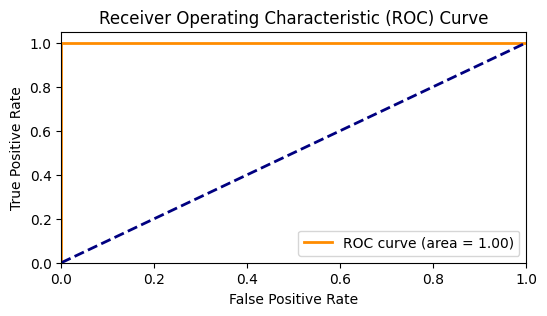

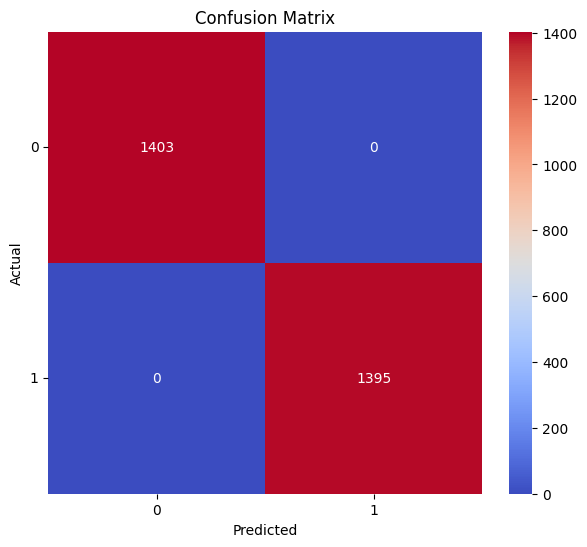

In [ ]:
if best_model_name == "ANN":
  # Predict on test set (ANN)
  X_test_processed = preprocessor.transform(X_test)
  y_pred = (best_model.predict(X_test_processed) > 0.5).astype("int32")
  y_proba = best_model.predict(X_test_processed)
  # Calculate metrics
  print("Classification metrics:")
  print(classification_report(y_test, y_pred))

else:
  # Predict on test set
  y_pred = best_pipeline.predict(X_test)

  # Calculate metrics
  print("Classification metrics:")
  print(classification_report(y_test, y_pred))

  # Predicted probabilities (for ROC curve)
  y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.show()

## 8. Feature Importance

In [ ]:
# Extract feature importance (for tree-based models)
try:
    # Get the model from the pipeline
    model = best_pipeline.named_steps['model']

    # Check if model has feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        # Get feature names after preprocessing
        preprocessor = best_pipeline.named_steps['preprocessor']

        feature_names = list(numerical_features)

        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        })

        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()

        print("Feature importance:")
        display(feature_importance)
    else:
        print("Feature importance not available for this model type.")
except Exception as e:
    print(f"Could not extract feature importance: {e}")

Could not extract feature importance: name 'best_pipeline' is not defined


## 9. Model Deployment and Saving

In [ ]:
if best_model_name == "ANN":
    print(best_model.output_shape)
    X_converted = np.array(X).astype('float32')
    y_converted = np.array(y).astype('float32').reshape(-1, 1)

    c_header = convert_model(best_model, X_converted, y_converted, model_name='smartLeleModel')
    print(c_header)

(None, 1)
Saved artifact at '/tmp/tmp95hhfj3j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor_88')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134211747667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134211675688400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134211675688016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134211675695504: TensorSpec(shape=(), dtype=tf.resource, name=None)
#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

// automatically configure network
#define TF_NUM_INPUTS 3
#define TF_NUM_OUTPUTS 1
#define TF_NUM_OPS 1
#define TF_OP_FULLYCONNECTED




## 10. Conclusion

### Summary of Findings

- Model Performance: [Add your observations about model performance]
- Key Features: [Summarize the most important features]
- Limitations: [Note any limitations of the current approach]